In [1]:
import re
import os
job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
job_id = job_ids[-1]
print('job_id', job_id)

import numpy as np
from matplotlib import pyplot as plt
from boutdata import collect
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from boutdata.data import BoutData

path        = './shared/NORTH/data_' + job_id + '/'
bdata = BoutData(path)
outputs = bdata['outputs']
options  =bdata['options']

field_keys = bdata['outputs'].keys()

from matplotlib import rcParams
rcParams.update({
    "font.size": 16})
rcParams['axes.titlepad'] = 20

def get_option(*keys):
    from numpy import sqrt
    val = options
    try:
        for key in keys:
            val = val[key]
        return eval(str(val))
    except:
        print('Error reading option for keys: ', keys)
        return 0

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

R, Te0, N_nuclei, mp, B0, e, mxg, myg = get_options([
    ('north', 'R'), ('north', 'Te0'), ('north', 'N_nuclei'),
    ('north', 'mp'), ('north', 'B0'), ('north', 'e'),
    (['mxg']), (['myg'])])
nx_all, ny_all, nz_all = get_options([('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
oci = get_option('north', 'oci')
rho_s = get_option('north', 'rho_s')
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

# Read data

field_list  = ['T', 'n', 'phi', 'vort','source_n', 'source_T','wall_shadow']
par_list    = ['t_array']

data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

job_id 5145562


/home/niflheim/s173965/.local/lib/python3.9/site-packages/boutdata/data.py:732: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  alwayswarn(


mxsub = 2 mysub = 1 mz = 256

nxpe = 40, nype = 1, npes = 40

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [2]:
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(1/(2*nx_inner), Lx+1/(2*nx_inner), nx_inner)

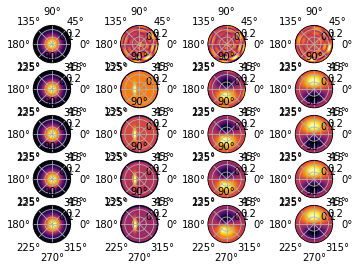

In [43]:
def plot_time_frames(cmap='inferno'):
    fields = ['n', 'T', 'vort', 'phi']
    frames = 5
    fig, axes = plt.subplots(frames,len(fields), subplot_kw={'projection': 'polar'})

    for i_field, field in enumerate(fields):
        field_data = data[field].squeeze()
        vmin = field_data.min()
        vmax = field_data.max()
        for frame in range(frames):
            axes[frame, i_field].contourf(thetas, rhos, field_data[frame, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
            axes[frame, i_field].set_rticks([])
            axes[frame, i_field].set_xticks([])

plot_time_frames()

    

In [ ]:
import numpy
import matplotlib.animation as animation

def animate_data(field, cmap='inferno', vmin = None, vmax = None):
    field_data = data[field].squeeze()
    if vmin is None:
        vmin = field_data.min()
    if vmax is None:
        vmax = field_data.max()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_rticks([])
    ax.set_xticks([])
    cont = ax.contourf(thetas, rhos, field_data[0, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)    # first image on screen
    fig.colorbar(cont, ax=ax)
    fig.tight_layout()

    # animation function
    def animate(i):
        for c in ax.collections:
            c.remove()  # removes only the contours, leaves the rest intact
        cont = ax.contourf(thetas, rhos, field_data[i, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
        return cont.collections
    
    anim = animation.FuncAnimation(fig, animate, frames=field_data.shape[0], interval=100, blit=True)
    anim.save('./plots/' + job_id + '_animation_' + field +'.gif', fps=4)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


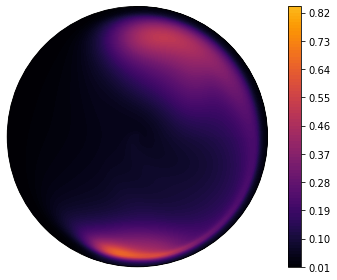

In [34]:
animate_data('n', vmin=0, vmax=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


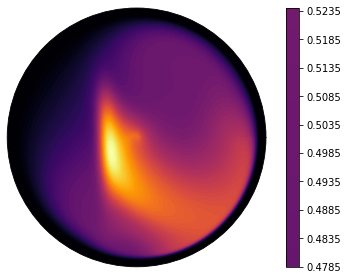

In [35]:
animate_data('T')

MovieWriter ffmpeg unavailable; using Pillow instead.


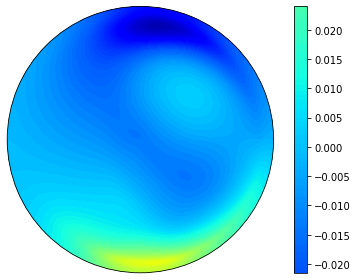

In [36]:
animate_data('vort', cmap='jet')

MovieWriter ffmpeg unavailable; using Pillow instead.


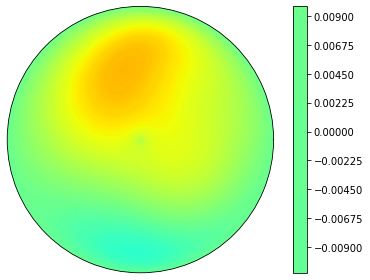

In [37]:
animate_data('phi', cmap='jet')